# Neuroscope

Jupyter workspace for the neuroscope project

In [37]:
import jax
from jax import vmap, jit, lax, random, grad, value_and_grad
import jax.numpy as jnp
import optax

import wandb
import numpy as np
from functools import partial
from tqdm import tqdm
import time
import seaborn as sns
import matplotlib.pyplot as plt

import syrkis
from src.data import load_subjects, make_kfolds

In [38]:
# GLOBALS
rng = random.PRNGKey(0)
cfg = syrkis.training.load_config()
cfg['image_size'] = 28 if cfg['dataset'] == 'mnist' else cfg['image_size']

In [39]:
def mnist_loader(rng, data_split):
    split_n_samples = data_split.shape[0]
    n_batches = split_n_samples // cfg['batch_size']
    
    while True:
        rng, key = jax.random.split(rng)
        idxs = jax.random.permutation(key, split_n_samples)
        for i in range(n_batches):
            batch_idxs = idxs[i * cfg['batch_size']:(i + 1) * cfg['batch_size']]
            yield None, None, data_split[batch_idxs], None

## Data

In [40]:
if 'subjects' not in locals() and cfg['dataset'] == 'neuroscope':
    subjects = load_subjects(['subj07'], cfg['image_size'])
    n_samples = sum([len(s[0]) for s in subjects.values()])
    kfolds = make_kfolds(subjects, cfg)
    train_batches, eval_batches = next(kfolds)
    lh_sample, rh_sample, img_sample, subject_idx_sample = next(train_batches)

if 'mnist_data' not in locals() and cfg['dataset'] == 'mnist':
    mnist_data = syrkis.data.mnist()
    n_samples = mnist_data[0].shape[0]
    mnist_train, mnist_eval = mnist_data[0][:55000], mnist_data[0][55000:]
    rng, train_rng, eval_rng = jax.random.split(rng, 3)
    train_batches = mnist_loader(train_rng, mnist_train)
    eval_batches = mnist_loader(eval_rng, mnist_eval)
    lh_sample, rh_sample, img_sample, subject_idx_sample = next(train_batches)



print(f'Number of samples: {n_samples}')
n_steps = n_samples // cfg['batch_size'] * cfg['epochs']
print(f'Number of steps: {n_steps}')
print(f'Number of batches: {n_steps // cfg["batch_size"]}')
print(f'Number of epochs: {cfg["epochs"]}')

Number of samples: 7872
Number of steps: 12300
Number of batches: 384
Number of epochs: 50


In [41]:
def glorot_init(rng, shape):
    if len(shape) == 2:  # Dense layer
        fan_in, fan_out = shape
    elif len(shape) == 4:  # Convolutional layer
        fan_in = shape[0] * shape[1] * shape[2]  # kernel_height * kernel_width * in_channels
        fan_out = shape[0] * shape[1] * shape[3]  # kernel_height * kernel_width * out_channels
    limit = jnp.sqrt(6 / (fan_in + fan_out))
    return jax.random.uniform(rng, shape, minval=-limit, maxval=limit)


def latent_side_fn(cfg):
    return cfg['image_size'] // cfg['stride'] ** cfg['conv_layers']


def latent_dim_fn(cfg):
    # should return the size of the latente dim depending on initial image size, stride, and number of layers, and channels
    image_size = cfg['image_size']
    stride = cfg['stride']
    layers = cfg['conv_layers']
    channels = 3 if cfg['dataset'] == 'neuroscope' else 1
    dim = image_size ** 2 * channels
    for i in range(layers):
        print(dim)
        dim = (dim * 2) // (stride ** 2)
    return dim
        


latent_dim = latent_dim_fn(cfg)
latent_side = latent_side_fn(cfg)
print(latent_dim)
print(latent_side)

12288
24576
49152
64


## Batch norm

In [42]:
@jit
def batch_norm(x, gamma, beta, eps=1e-5):
    if not cfg['batch_norm']:
        return x
    # x: batch x height x width x channels
    axis = tuple(range(len(x.shape) - 1))
    mean = jnp.mean(x, axis=axis, keepdims=True)
    var = jnp.var(x, axis=axis, keepdims=True)
    x = (x - mean) / jnp.sqrt(var + eps)
    x = gamma * x + beta
    return x

def init_batch_norm(shape):
    shape = [1 for _ in range(len(shape) - 1)] + [shape[-1]]
    shape = tuple(shape)
    gamma = jnp.ones(shape)
    beta = jnp.zeros(shape)
    return gamma, beta

## Linear layer

In [43]:
def init_linear_layer(rng, in_dim, out_dim, tensor_dim):
    # tensor dim is for having fmri embedding in same array, but seperate layers.
    rng, key = jax.random.split(rng, 2)
    w_shape = (in_dim, out_dim)
    b_shape = (out_dim,)
    w = glorot_init(key, w_shape)
    if tensor_dim > 0:
        w = w.reshape((-1, out_dim, tensor_dim))
    b = jnp.zeros(b_shape)
    gamma, beta = init_batch_norm(b_shape)
    return w, b, gamma, beta

def init_linear_layers(rng, in_dim, out_dim, cfg, tensor_dim=0):
    # first layer goes from in_dim to embed_dim, rest are embed to embed, and last is embed to out
    rngs = jax.random.split(rng, cfg['fc_layers'])
    params = []
    for idx, rng in enumerate(rngs):
        layer_in_dim  = cfg['embed_dim'] if idx != 0                    else in_dim
        layer_out_dim = cfg['embed_dim'] if idx != cfg['fc_layers'] - 1 else out_dim
        params.append(init_linear_layer(rng, layer_in_dim, layer_out_dim, tensor_dim))
    return params

def linear(params, x):
    for idx, (w, b, gamma, beta) in enumerate(params):
        x = x @ w + b
        x = jax.nn.gelu(x) if idx != len(params) - 1 else x
        x = batch_norm(x, gamma, beta) if idx != len(params) - 1 else x
    return x

def test_linear():
    cfg = syrkis.training.load_config()
    rng = jax.random.PRNGKey(0)
    x = jnp.array([1.0, 2.0])
    params = init_linear_layers(rng, 2, 4, cfg)
    y = linear(params, x)
    assert y.shape == (4,)
    print(y)

test_linear()

[-1.9884775   0.638638    1.3899286  -0.11827302]


## Convolutions

In [44]:
# Global constants for common parameters
DIMENSION_NUMBERS = ("NHWC", "HWIO", "NHWC")


@jit
def conv2d(x, w):
    return jax.lax.conv_general_dilated(
        x, w, 
        window_strides=(cfg['stride'], cfg['stride']),
        padding='SAME',
        dimension_numbers=DIMENSION_NUMBERS)


@jit
def upscale_nearest_neighbor(x, scale_factor=cfg['stride']):
    # Assuming x has shape (batch, height, width, channels)
    b, h, w, c = x.shape
    x = x.reshape(b, h, 1, w, 1, c)
    x = lax.tie_in(x, jnp.broadcast_to(x, (b, h, scale_factor, w, scale_factor, c)))
    return x.reshape(b, h * scale_factor, w * scale_factor, c)


@jit
def deconv2d(x, w):
    x_upscaled = upscale_nearest_neighbor(x)
    return lax.conv_transpose(
        x_upscaled, w, 
        strides=(1, 1), 
        padding='SAME',
        dimension_numbers=DIMENSION_NUMBERS) 


def conv_fn(fn):
    def apply_fn(params, x):
        for i, (w, b, gamma, beta) in enumerate(params):
            x = fn(x, w, b)
            x = batch_norm(x, gamma, beta) if i != len(params) - 1 else x
            x = jax.nn.gelu(x) if i != len(params) - 1 else x
        return x
    return apply_fn


conv   = conv_fn(lambda x, w, b: conv2d(x, w) + b)
deconv = conv_fn(lambda x, w, b: deconv2d(x, w) + b)


def init_conv_params(rng, chan, cfg, deconv=False):
    rng, key = jax.random.split(rng, 2)
    in_chan  = chan * 2 if deconv else chan
    out_chan = chan if deconv else chan * 2 
    w_shape = (cfg['kernel_size'], cfg['kernel_size'], in_chan, out_chan)
    w = glorot_init(key, w_shape)
    b = jnp.zeros((out_chan,))
    gamma, beta = init_batch_norm(b.shape)
    return w, b, gamma, beta


def init_conv_layers(rng, cfg, deconv=False):
    ds_channels = 3 if cfg['dataset'] == 'neuroscope' else 1
    rngs = jax.random.split(rng, cfg['conv_layers'])
    params = []
    for idx, rng in enumerate(rngs):
        channels = ds_channels * 2 ** idx
        params.append(init_conv_params(rng, channels, cfg, deconv))
    return params[::-1] if deconv else params


def test_conv():
    channels = 3 if cfg['dataset'] == 'neuroscope' else 1
    x = jnp.ones((cfg['batch_size'], cfg['image_size'], cfg['image_size'], channels))
    conv_params = init_conv_layers(jax.random.PRNGKey(0), cfg)
    deconv_params = init_conv_layers(jax.random.PRNGKey(0), cfg, deconv=True)
    z = conv(conv_params, x)
    x_hat = deconv(deconv_params[:3], z)

test_conv()

## Model

In [45]:
def print_model(params):
    print(f'{syrkis.training.n_params(params)} total params', end='\n\n')
    print('\tconv params')
    for idx, (w, b, gamma, beta) in enumerate(params['conv']):
        print(f'\t\tconv_{idx}\t\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
    for idx, (w, b, gamma, beta) in enumerate(params['deconv']):
        print(f'\t\tdeconv_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
    print('\n\tlinear params')
    for idx, (w, b, gamma, beta) in enumerate(params['linear_encode']):
        print(f'\t\tencode_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
    for idx, (w, b, gamma, beta) in enumerate(params['linear_decode']):
        print(f'\t\tdecode_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')

In [46]:


def encode_img_fn(params, img):
    z = jax.nn.gelu(conv(params['conv'], img))
    z = z.reshape(cfg['batch_size'], -1)
    z = jax.nn.gelu(linear(params['linear_encode'], z))
    return z

def matmul_slice(A, B_slice):
    return jnp.dot(A, B_slice)
batched_matmul = vmap(matmul_slice, in_axes=(None, 2))

def encode_fmri_fn(params, fmri, subj):
    embed_cube = params['fmri_embed'][0][0]            # fmri_dim  x embed_dim x n_subjects
    z = batched_matmul(fmri, embed_cube)               # n_subjects x batch_size x embed_dim
    z = z.transpose((2, 0, 1))                         # embed_dim x n_subjects x batch_size    # prep for broadcast
    one_hot = jax.nn.one_hot(subj, len(subjects)).T    # n_subjects x batch_size                # prep for broadcast
    z = one_hot * z                                    # embed_dim x n_subjects x batch_size    # one subject dimension has zeros after broadcast
    z = z.sum(axis=1).T                                # batch_size x embed_dim                 # sum over subjects
    z = jax.nn.gelu(linear(params['fmri_dense'], z))
    return z

def decode_fn(params, z):
    z = jax.nn.gelu(linear(params['linear_decode'], z))
    z = z.reshape(cfg['batch_size'], latent_side, latent_side, -1)
    z = deconv(params['deconv'], z)
    return jax.nn.sigmoid(z)

@jit
def apply_fn(params, fmri, img, subj):
    if cfg['dataset'] == 'mnist' or cfg['source'] == 'img':
        z = encode_img_fn(params, img)
    else:
        z = encode_fmri_fn(params, fmri, subj)
    x_hat = decode_fn(params, z)   # reparametrize(mu, logvar, rng))
    return x_hat

def loss_fn(params, fmri, img, subj):
    x_img = apply_fn(params, fmri, img, subj)
    return jnp.mean((img - x_img) ** 2)

def update_fn(params, fmri, img, subj, opt_state, opt):
    loss, grads = value_and_grad(loss_fn)(params, fmri, img, subj)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

def init_fn(rng, cfg):

    if cfg['dataset'] == 'mnist' or cfg['source'] == 'img':
        conv_params = init_conv_layers(rng, cfg)
        linear_encode_params = init_linear_layers(rng, latent_dim, cfg['embed_dim'], cfg)  # linear layers
        linear_decode_params = init_linear_layers(rng, cfg['embed_dim'], latent_dim, cfg)  # linear layers
        deconv_params = init_conv_layers(rng, cfg, deconv=True)
        params = {"conv": conv_params, "deconv": deconv_params,
                  "linear_encode": linear_encode_params, "linear_decode": linear_decode_params}

    if cfg['dataset'] != 'mnist' and cfg['source'] == 'fmri':
        fmri_embed_params = init_linear_layers(rng, 19004 * len(subjects), cfg['embed_dim'], cfg, tensor_dim=len(subjects))  # linear layers
        fmri_dense_params = init_linear_layers(rng, cfg['embed_dim'], cfg['embed_dim'], cfg)  # linear layers
        linear_decode_params = init_linear_layers(rng, cfg['embed_dim'], latent_dim, cfg)  # linear layers
        deconv_params = init_conv_layers(rng, cfg, deconv=True)
        params = {"fmri_embed": fmri_embed_params, "fmri_dense": fmri_dense_params,
                  "deconv": deconv_params, "linear_decode": linear_decode_params}

    return params


def print_model(params):
    print(f'{syrkis.training.n_params(params)} total params', end='\n\n')
    if cfg['dataset'] == 'mnist' or cfg['source'] == 'img':
        print('\tconv params')
        for idx, (w, b, gamma, beta) in enumerate(params['conv']):
            print(f'\t\tconv_{idx}\t\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
        for idx, (w, b, gamma, beta) in enumerate(params['deconv']):
            print(f'\t\tdeconv_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
        print('\n\tlinear params')
        for idx, (w, b, gamma, beta) in enumerate(params['linear_encode']):
            print(f'\t\tencode_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
        for idx, (w, b, gamma, beta) in enumerate(params['linear_decode']):
            print(f'\t\tdecode_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
    if cfg['dataset'] != 'mnist' and cfg['source'] == 'fmri':
        print('\tfmri params')
        for idx, (w, b, gamma, beta) in enumerate(params['fmri_embed']):
            print(f'\t\tfmri_embed_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
        for idx, (w, b, gamma, beta) in enumerate(params['fmri_dense']):
            print(f'\t\tfmri_dense_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
        for idx, (w, b, gamma, beta) in enumerate(params['linear_decode']):
            print(f'\t\tdecode_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
        for idx, (w, b, gamma, beta) in enumerate(params['deconv']):
            print(f'\t\tdeconv_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')



## Training

In [47]:
rng = jax.random.PRNGKey(0)
params = init_fn(rng, cfg)
print_model(params)

12732453 total params

	conv params
		conv_0		: 168	|	3 x 3 x 3 x 6
		conv_1		: 660	|	3 x 3 x 6 x 12
		deconv_0	: 654	|	3 x 3 x 12 x 6
		deconv_1	: 165	|	3 x 3 x 6 x 3

	linear params
		encode_0	: 6291584	|	49152 x 128
		decode_0	: 6340608	|	128 x 49152



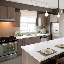
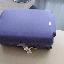
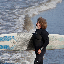
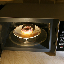
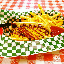
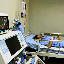
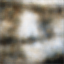
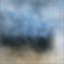
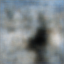
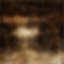
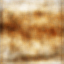
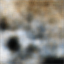
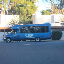
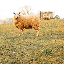
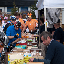
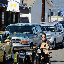
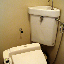
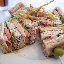
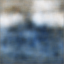
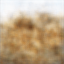
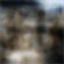
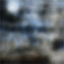
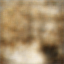
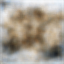

KeyboardInterrupt: 

In [48]:

opt = optax.adamw(cfg['lr'], weight_decay=0.02)
opt_state = opt.init(params)
update = jit(partial(update_fn, opt=opt))

def evaluate(params, train_batches, eval_batches, eval_steps=5):
    train_loss, eval_loss = 0, 0
    for i in range(eval_steps):
        lh_train, rh_train, train_img, subj_train = next(train_batches)
        lh_eval, rh_eval, eval_img, subj_eval = next(eval_batches)
        train_loss += loss_fn(params, lh_train, train_img, subj_train) / eval_steps
        eval_loss += loss_fn(params, lh_eval, eval_img, subj_eval) / eval_steps
    return train_loss, eval_loss


train_eval_lh, train_eval_rh, train_eval_img, train_eval_subj = next(train_batches)
def train(params, opt_state, cfg, train_batches, eval_batches, eval_step=100, monitor=False):
    if monitor:
        wandb.init(project="neuroscope", entity="syrkis", config=cfg)
    for step in range(n_steps):
        lh, rh, img, subj = next(train_batches)
        params, opt_state, loss = update(params, lh, img, subj, opt_state)
        info_bar = [f"loss : {loss:.4f}", f"step : {step} / {n_steps}"]
        imgs = [img_sample[:6], apply_fn(params, lh, img_sample, subject_idx_sample)[:6],
                train_eval_img[:6], apply_fn(params, train_eval_lh, train_eval_img, train_eval_subj)[:6]]
        syrkis.training.plot_multiples(jnp.concatenate(imgs, axis=0), n_rows=4, info_bar=info_bar, invertable=cfg['dataset'] == 'mnist')
        # monitor eval_bin times throughout training
        if monitor and step % eval_step == 0:
            train_loss, eval_loss = evaluate(params, train_batches, eval_batches)
            wandb.log({"train_loss": train_loss, "eval_loss": eval_loss})
    wandb.finish()

train(params, opt_state, cfg, train_batches, eval_batches, monitor=False)
z = conv(params['conv'], img_sample)
z = z.reshape(cfg['batch_size'], -1)
print(z.shape)
print(params['linear_encode'][0][0].shape)